In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')
if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import division, print_function

import numpy as np

from astropy import units as u
from astropy import table
from astropy.coordinates import SkyCoord

In [3]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = [10.0, 6.0]

# Hosts 

Hosts are identified in the [HSC overlap check](HSC%20overlap%20check.ipynb) notebook.  For DR1 they are (in "300 kpc" circles):

* Alice: 75%
* Othello: 66%
* Dune: 100%

In [4]:
import hosts

In [5]:
hostobjs = hosts.get_saga_hosts_from_google()
hosts.use_base_catalogs(hostobjs)
hschosts = tuple([h for h in hostobjs if h.name in ('Alice', 'Othello', 'Dune')])
assert len(hschosts) == 3
hschosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


(<hosts.NSAHost object w/ name 'Alice' AKA: ['NGC4030', 'NSA140594']>,
 <hosts.NSAHost object w/ name 'Dune' AKA: ['NGC5750', 'NSA165536']>,
 <hosts.NSAHost object w/ name 'Othello' AKA: ['NGC5792', 'NSA145729']>)

In [6]:
for h in hschosts:
    h.hscfn = os.path.join('catalogs', 'hsc_pdr1_{}.csv.gz'.format(h.name))

# Generate queries 

These queries are meant for the HSC casjobs at https://hsc-release.mtk.nao.ac.jp/datasearch/ (which requires login)

In [7]:
hsc_qry_templ="""
SELECT {cols}
FROM {table}
WHERE coneSearch(coord, {hra}, {hdec}, {radius})
"""[1:-1]

bands = 'gri'
cols = 'object_id,ra,dec'.split(',')
for band in bands:
    magcol_to_add = []
    magcol_to_add.append('{}cmodel_mag'.format(band))
    magcol_to_add.append('{}mag_psf'.format(band))
    magcol_to_add.append('{}mag_kron'.format(band))
    magcol_to_add.append('{}mag_aperture10'.format(band))
    magcol_to_add.append('{}mag_aperture20'.format(band))
    magcol_to_add.append('{}mag_aperture30'.format(band))
    for magcol in magcol_to_add:
        cols.append(magcol)
        cols.append(magcol+'_err')
    
    cols.append('{}flux_kron_radius'.format(band))
    cols.append('a_{}'.format(band))
cols = ','.join(cols)

In [8]:
table_to_query='pdr1_wide.forced'

for h in hschosts:
    print('Query for host', h.name, 'which should be saved to', h.hscfn)
    qry = hsc_qry_templ.format(table=table_to_query, cols=cols,
                               hra=h.ra, hdec=h.dec, 
                               radius=h.environsarcmin*u.arcmin.to(u.arcsec))
    print(qry, '\n')

Query for host Alice which should be saved to catalogs/hsc_pdr1_Alice.csv.gz
SELECT object_id,ra,dec,gcmodel_mag,gcmodel_mag_err,gmag_psf,gmag_psf_err,gmag_kron,gmag_kron_err,gmag_aperture10,gmag_aperture10_err,gmag_aperture20,gmag_aperture20_err,gmag_aperture30,gmag_aperture30_err,gflux_kron_radius,a_g,rcmodel_mag,rcmodel_mag_err,rmag_psf,rmag_psf_err,rmag_kron,rmag_kron_err,rmag_aperture10,rmag_aperture10_err,rmag_aperture20,rmag_aperture20_err,rmag_aperture30,rmag_aperture30_err,rflux_kron_radius,a_r,icmodel_mag,icmodel_mag_err,imag_psf,imag_psf_err,imag_kron,imag_kron_err,imag_aperture10,imag_aperture10_err,imag_aperture20,imag_aperture20_err,imag_aperture30,imag_aperture30_err,iflux_kron_radius,a_i
FROM pdr1_wide.forced
WHERE coneSearch(coord, 180.09842901, -1.10007802185, 2691.60292683) 

Query for host Dune which should be saved to catalogs/hsc_pdr1_Dune.csv.gz
SELECT object_id,ra,dec,gcmodel_mag,gcmodel_mag_err,gmag_psf,gmag_psf_err,gmag_kron,gmag_kron_err,gmag_aperture10,gmag_

# Alice Catalog Experiments

In [9]:
def compute_ap_sb(mags, aperturerad):
    A = 2.5*np.log10(np.pi*(aperturerad.to(u.arcsec).value)**2)
    return np.array(mags + A) * u.mag * u.arcsec**-2

In [10]:
alice = [h for h in hostobjs if h.name=='Alice']
assert len(alice)==1
alice = alice[0]

In [11]:
alice.hsc_cat = table.Table.read(alice.hscfn, format='ascii.csv')
alice.hsc_cat['# object_id'].name = 'object_id'
alice.hsc_cat

object_id,ra,dec,gcmodel_mag,gcmodel_mag_err,gmag_psf,gmag_psf_err,gmag_kron,gmag_kron_err,gmag_aperture10,gmag_aperture10_err,gmag_aperture20,gmag_aperture20_err,gmag_aperture30,gmag_aperture30_err,gflux_kron_radius,a_g,rcmodel_mag,rcmodel_mag_err,rmag_psf,rmag_psf_err,rmag_kron,rmag_kron_err,rmag_aperture10,rmag_aperture10_err,rmag_aperture20,rmag_aperture20_err,rmag_aperture30,rmag_aperture30_err,rflux_kron_radius,a_r,icmodel_mag,icmodel_mag_err,imag_psf,imag_psf_err,imag_kron,imag_kron_err,imag_aperture10,imag_aperture10_err,imag_aperture20,imag_aperture20_err,imag_aperture30,imag_aperture30_err,iflux_kron_radius,a_i
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
41108545034256385,180.08726146,-1.40139313589,nan,nan,nan,nan,nan,nan,25.0647144,0.0391006023,nan,nan,nan,nan,nan,0.0901541635,nan,nan,nan,nan,nan,nan,24.7278309,0.0412764698,nan,nan,nan,nan,nan,0.0638859197,nan,nan,nan,nan,nan,nan,24.4870815,0.0427338928,nan,nan,nan,nan,nan,0.0455929674
41108545034256386,180.067552591,-1.39981983914,24.3663807,0.0254170056,24.3672333,0.025104655,24.443491,0.0368659012,24.8210564,0.0280307774,24.4597397,0.0394332744,24.4106483,0.056278497,0.362650841,0.0893580765,23.0538254,0.00934208184,23.0551853,0.00930565037,23.0989609,0.015546673,23.3599434,0.0105742812,23.1640511,0.0171450842,23.1355972,0.0250035934,0.362650841,0.0633217841,22.5629864,0.00659706164,22.5638466,0.0065631303,22.5821228,0.0115877623,22.8502178,0.00791515037,22.6387405,0.0125424415,22.586113,0.0176858064,0.362650841,0.0451903641
41108545034256387,180.066260836,-1.40140046234,nan,nan,nan,nan,nan,nan,26.8673096,0.18593888,nan,nan,nan,nan,nan,0.0893126726,nan,nan,nan,nan,nan,nan,26.5079422,0.19236137,nan,nan,nan,nan,nan,0.0632896125,nan,nan,nan,nan,nan,nan,26.1212807,0.146682844,nan,nan,nan,nan,nan,0.0451674052
41108545034256388,180.062107353,-1.40140188906,nan,nan,nan,nan,nan,nan,27.7119274,0.405397326,nan,nan,nan,nan,nan,0.089106448,nan,nan,nan,nan,nan,nan,25.9073753,0.113375291,nan,nan,nan,nan,nan,0.0631434768,nan,nan,nan,nan,nan,nan,25.5106106,0.0877475813,nan,nan,nan,nan,nan,0.0450631119
41108545034256389,180.049693498,-1.4012661411,nan,nan,nan,nan,nan,nan,25.5707893,0.058872249,24.8453484,0.0602041632,nan,nan,nan,0.0889777243,nan,nan,nan,nan,nan,nan,25.0995235,0.052973859,24.2976265,0.0514290482,nan,nan,nan,0.0630522594,nan,nan,nan,nan,nan,nan,24.3176727,0.0276471656,23.4508495,0.025119897,nan,nan,nan,0.0449980125
41108545034256390,180.043253237,-1.40140827291,nan,nan,nan,nan,nan,nan,27.9370613,0.490639031,nan,nan,nan,nan,nan,0.0893190503,nan,nan,nan,nan,nan,nan,26.9966412,0.283427835,nan,nan,nan,nan,nan,0.063294135,nan,nan,nan,nan,nan,nan,26.338913,0.164360657,nan,nan,nan,nan,nan,0.0451706313
41108545034256391,180.039286383,-1.40140959674,nan,nan,nan,nan,nan,nan,27.2692108,0.256713986,nan,nan,nan,nan,nan,0.0895407796,nan,nan,nan,nan,nan,nan,27.0035515,0.282018602,nan,nan,nan,nan,nan,0.0634512529,nan,nan,nan,nan,nan,nan,26.2702637,0.158590898,nan,nan,nan,nan,nan,0.0452827625
41108545034256392,180.036252837,-1.40103735469,25.4858875,0.0881770775,nan,nan,nan,nan,26.0827637,0.0915243328,25.6427879,0.123142719,25.4058743,0.147951245,nan,0.0897036195,25.2887478,0.0944700837,nan,nan,nan,nan,25.9267731,0.10127084,25.2838669,0.113004774,25.0307369,0.135821059,nan,0.0635666475,25.2616844,0.0899407715,nan,nan,nan,nan,25.7460995,0.0969218016,25.3558254,0.13799715,25.1204281,0.167994276,nan,0.0453651138
41108545034256393,180.032518882,-1.39856580545,nan,nan,18.6967316,0.000617610291,18.0127697,0.000634397555,19.1319542,0.000666272652,18.2778149,0.000463953853,18.1407127,0.000448998122,1.77118564,0.0900523365,nan,nan,19.2680569,0.00120057061,17.6872921,0.000779373338,

In [12]:
alice.hsc_cat['coord'] = SkyCoord.guess_from_table(alice.hsc_cat, unit=u.deg)

In [14]:
alice.hsc_cat['r_sb10'] = compute_ap_sb(alice.hsc_cat['rmag_aperture10'], 0.5*u.arcsec)
alice.hsc_cat['r_sb20'] = compute_ap_sb(alice.hsc_cat['rmag_aperture20'], 1.0*u.arcsec)
alice.hsc_cat['r_sb_kron'] = compute_ap_sb(alice.hsc_cat['rmag_kron'], alice.hsc_cat['rflux_kron_radius']*u.arcsec)

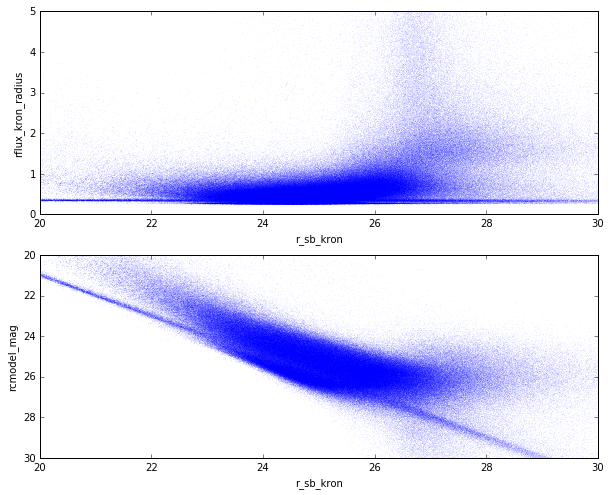

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 8))

Ar = alice.hsc_cat['a_r']
ax1.scatter(alice.hsc_cat['r_sb_kron']-Ar, alice.hsc_cat['rflux_kron_radius'], alpha=.05, s=1, lw=0)
ax2.scatter(alice.hsc_cat['r_sb_kron']-Ar, alice.hsc_cat['rcmodel_mag']-Ar, alpha=.05, s=1, lw=0)

for ax in (ax1, ax2):
    ax.set_xlim(20, 30)
    ax.set_xlabel('r_sb_kron')
ax1.set_ylim(0, 5)
ax2.set_ylim(30, 20)

ax1.set_ylabel('rflux_kron_radius')
ax2.set_ylabel('rcmodel_mag')

## Write out 

In [22]:
coo = alice.hsc_cat['coord']
del alice.hsc_cat['coord']
alice.hsc_cat.write('catalogs/Alice_HSC_reprocessed.fits', format='fits')
!gzip catalogs/Alice_HSC_reprocessed.fits
!ls -lh catalogs/Alice*
coo = alice.hsc_cat['coord'] = coo

-rw-r--r--@ 1 erik  staff    35M Mar 26  2015 catalogs/Alice in Wonderland_sdss.dat
-rw-r--r--@ 1 erik  staff   2.6M Mar 26  2015 catalogs/Alice in Wonderland_usnob.dat
-rw-r--r--@ 1 erik  staff    35M Mar 26  2015 catalogs/AliceInWonderland_sdss.dat
-rw-r--r--  1 erik  staff   300M Aug 16 16:26 catalogs/Alice_HSC_reprocessed.fits.gz
-rw-r--r--  1 erik  staff   327M Aug 16 16:05 catalogs/Alice_decals_dr3.fits


## Matches with SDSS 

In [24]:
sdsscat = alice.get_sdss_catalog()
idx, d2d, _ = sdsscat['coord'].match_to_catalog_sky(alice.hsc_cat['coord'])

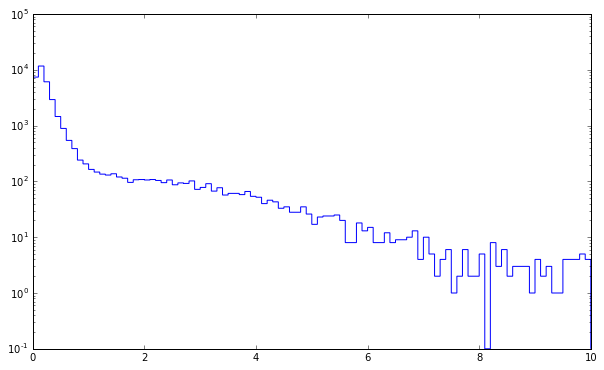

In [25]:
plt.hist(d2d.arcsec, range=(0, 10), log=True, bins=100, histtype='step');

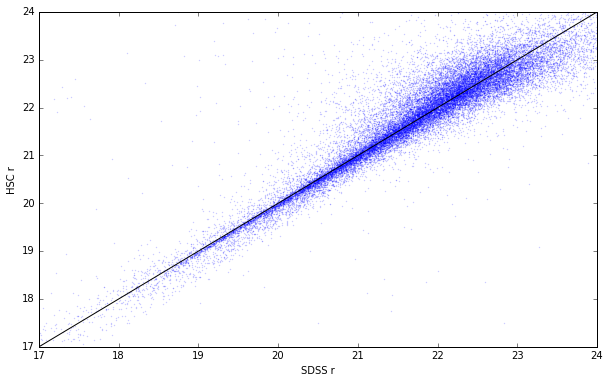

In [26]:
matched = d2d < 1*u.arcsec
plt.scatter(sdsscat['r'][matched], alice.hsc_cat['rcmodel_mag'][idx[matched]], alpha=.2, lw=0, s=2)
plt.plot([17, 24], [17, 24], c='k')
plt.xlim(17, 24)
plt.ylim(17, 24)
plt.xlabel('SDSS r')
plt.ylabel('HSC r')

## Matches with DECaLS 

In [27]:
deccat = table.Table.read('catalogs/Alice_decals_dr3.fits')

In [28]:
deccat['coord'] = SkyCoord(deccat['ra'], deccat['dec'], unit=u.deg)
idx, d2d, _ = deccat['coord'].match_to_catalog_sky(alice.hsc_cat['coord'])

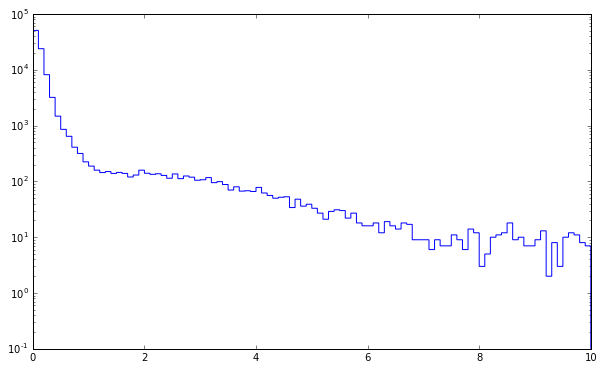

In [29]:
plt.hist(d2d.arcsec, range=(0, 10), log=True, bins=100, histtype='step');

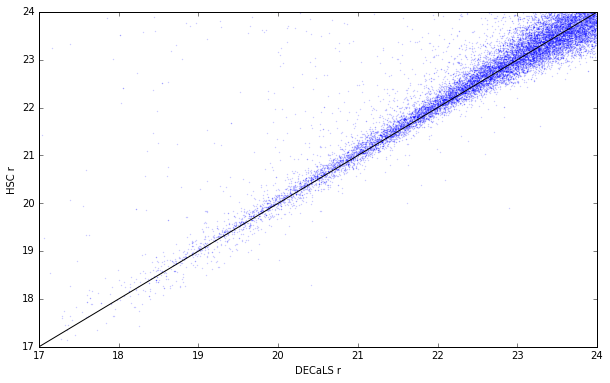

In [30]:
matched = d2d < 1*u.arcsec
plt.scatter(deccat['mag_r'][matched], alice.hsc_cat['rcmodel_mag'][idx[matched]], alpha=.2, lw=0, s=2)
plt.plot([17, 24], [17, 24], c='k')
plt.xlim(17, 24)
plt.ylim(17, 24)
plt.xlabel('DECaLS r')
plt.ylabel('HSC r')